In [13]:
from utils import *
#from kg_gen_4_onlyProts import *
import pickle
from kg_gen_3 import *

from IPython.display import Markdown, display

In [14]:
data = pd.read_excel('../data/chembl_search_nd.xlsx')
chembl = list(set(data['chembl_id']))
len(chembl)

46

In [15]:
data.head()

,chembl_id,pref_name,canonical_smiles,standard_inchi,standard_inchi_key,max_phase,indication_class,withdrawn_flag,black_box_warning,drugind_id,max_phase_for_ind,mesh_id,mesh_heading,ref_type,ref_id,ref_url
0,CHEMBL1200689,NITRIC OXIDE,[N]=O,InChI=1S/NO/c1-2,MWUXSHHQAYIFBG-UHFFFAOYSA-N,4,NaN,0,0,23580,3,D016773,"Leishmaniasis, Cutaneous",ClinicalTrials,NCT00317629,https://clinicaltrials.gov/ct2/results?id=%22N...
1,CHEMBL131,PREDNISOLONE,C[C@]12C=CC(=O)C=C1CC[C@@H]1[C@@H]2[C@@H](O)C[...,InChI=1S/C21H28O5/c1-19-7-5-13(23)9-12(19)3-4-...,OIGNJSKKLXVSLS-VWUMJDOOSA-N,4,Glucocorticoid,0,0,24801,2,D007918,Leprosy,ClinicalTrials,"NCT00919542,NCT00919776,NCT00919815",https://clinicaltrials.gov/ct2/results?id=%22N...
2,CHEMBL160,CYCLOSPORINE,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,InChI=1S/C62H111N11O12/c1-25-27-28-40(15)52(75...,PMATZTZNYRCHOR-CGLBZJNRSA-N,4,Immunosuppressant,0,1,25201,2,D007918,Leprosy,ClinicalTrials,"NCT00919451,NCT00919542,NCT00919776,NCT00919815",https://clinicaltrials.gov/ct2/results?id=%22N...
3,CHEMBL628,PENTOXIFYLLINE,CC(=O)CCCCn1c(=O)c2c(ncn2C)n(C)c1=O,InChI=1S/C13H18N4O3/c1-9(18)6-4-5-7-17-12(19)1...,BYPFEZZEUUWMEJ-UHFFFAOYSA-N,4,Vasodilator,0,0,26814,2,D016773,"Leishmaniasis, Cutaneous",ClinicalTrials,"NCT01381055,NCT01464242",https://clinicaltrials.gov/ct2/results?id=%22N...
4,CHEMBL1631694,FEXINIDAZOLE,CSc1ccc(OCc2ncc([N+](=O)[O-])n2C)cc1,InChI=1S/C12H13N3O3S/c1-14-11(13-7-12(14)15(16...,MIWWSGDADVMLTG-UHFFFAOYSA-N,4,NaN,0,0,40610,2,D007898,"Leishmaniasis, Visceral",ClinicalTrials,NCT01980199,https://clinicaltrials.gov/ct2/results?id=%22N...


# Part 1: Working with drugs

In [16]:
#Retrieve active assays (B|F) and target proteins
chem2act = RetAct(chembl)

Retrieving bioassays from ChEMBL:   0%|          | 0/46 [00:00<?, ?it/s]

In [17]:
#Retrieve mech of actions
chem2mech = RetMech(chembl)

Retrieving mechanisms from ChEMBL:   0%|          | 0/46 [00:00<?, ?it/s]

In [19]:
#Retrieve disease indications
chembl2dis = RetDrugInd(chembl)

Retrieving diseases from ChEMBL:   0%|          | 0/46 [00:00<?, ?it/s]

In [20]:
#get proteins from chem2act and chem2mech from above. They have their own set of target proteins

prtn_as_chembl = Ret_chembl_protein(chem2act) + Ret_chembl_protein(chem2mech)
prtn_as_chembl = list(set(prtn_as_chembl))
len(prtn_as_chembl)

67

In [ ]:
# #put the prots together
# prot = prot + prtn_as_chembl
# prot = list(set(prot))
# len(prot)

In [22]:
#fetch gene symbols for proteins with chembl ids and extend to known pathways they are involved in

chembl2uprot = chembl2uniprot(prtn_as_chembl)

Filtering UniProt proteins from ChEMBL:   0%|          | 0/67 [00:00<?, ?it/s]

Filtering human proteins from ChEMBL:   0%|          | 0/64 [00:00<?, ?it/s]

Populating ChEMBL data for human proteins:   0%|          | 0/58 [00:00<?, ?it/s]

In [24]:
#update chembl protein with gene symbols
chembl2act = chembl2gene2path(chembl2uprot, chem2act)
chembl2mech = chembl2gene2path(chembl2uprot, chem2mech)

In [25]:
#Adv effect for drugs
advEff = GetAdverseEvents(chembl)

Retrieving Adverse Effects for each drug:   0%|          | 0/46 [00:00<?, ?it/s]

In [26]:
#Drug warnings for drugs
drugWarn = GetDrugWarnings(chembl)

Retrieving drug warnings for each drug:   0%|          | 0/46 [00:00<?, ?it/s]

# Part 2: Working with Proteins

# Using API from https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0325-4 integrated in ChEMBL to fetch targeted predictions

In [27]:
chem_df = GetSmiles(pd.DataFrame(chembl,columns=['drugId']))

Getting SMILES for CHEMBL ids and generating descriptors:   0%|          | 0/46 [00:00<?, ?it/s]

In [28]:
#Fetch targeted predictions for drugs from chembl, Threshold: 90%, usecase: NTD

final_df = pd.DataFrame()

#for smiles in tqdm(chem_df['smiles']):
for i in tqdm(range(len(chem_df))):
    
    headers = {
    'Content-Type': 'application/json',
    }

    json_data = {
        'smiles': chem_df['smiles'][i],
    }

    response = requests.post('https://www.ebi.ac.uk/chembl/target-predictions', headers=headers, json=json_data)
    response = response.json()
    response = pd.DataFrame(response)
    #print(type(response))
    #print(response)
    
    #if not response.emtpy:
    response = response[(response['organism']=='Homo sapiens') & (response['90%']=='active')]
    response['drugid'] = chem_df['drugId'][i]
        
    #if not response.emtpy:
    final_df = pd.concat([final_df,response])
    
    

  0%|          | 0/46 [00:00<?, ?it/s]

In [29]:
final_df.reset_index(drop=True, inplace=True)

In [30]:
final_df.head(5)

,target_chemblid,organism,pref_name,70%,80%,90%,threshold,drugid
0,CHEMBL2157850,Homo sapiens,Ubiquitin carboxyl-terminal hydrolase 7,empty,empty,active,6.0,CHEMBL370143
1,CHEMBL4618,Homo sapiens,Leukotriene A4 hydrolase,empty,active,active,6.0,CHEMBL370143
2,CHEMBL5880,Homo sapiens,Interleukin-2,active,active,active,6.0,CHEMBL370143
3,CHEMBL2111432,Homo sapiens,PI3-kinase p110-delta/p85-alpha,active,active,active,6.0,CHEMBL370143
4,CHEMBL3004,Homo sapiens,Multidrug resistance-associated protein 1,empty,empty,active,6.0,CHEMBL370143


In [31]:
#Retrieve proteins and convert to uniprot 
chem2uni = chembl2uniprot(list(set(final_df['target_chemblid'])))

Filtering UniProt proteins from ChEMBL:   0%|          | 0/141 [00:00<?, ?it/s]

Filtering human proteins from ChEMBL:   0%|          | 0/141 [00:00<?, ?it/s]

Populating ChEMBL data for human proteins:   0%|          | 0/141 [00:00<?, ?it/s]

In [32]:
#temp_df=pd.DataFrame(columns=['target_chemblid','uniprot','symbol'])
temp_list = []
#temp = []
for key in chem2uni:
    temp = []

    temp.append(key)
    temp.append(chem2uni[key][-2]['accession'])
    temp.append(chem2uni[key][-1]['component_synonym'])

    temp_list.append(temp)


In [33]:
temp_df = pd.DataFrame(temp_list,columns=['target_chemblid','uniprot','symbol'])

In [34]:
merge_df = final_df.merge(temp_df[["target_chemblid", "uniprot", "symbol"]])

In [35]:
len(merge_df)

825

In [36]:
merge_df.head()

,target_chemblid,organism,pref_name,70%,80%,90%,threshold,drugid,uniprot,symbol
0,CHEMBL2157850,Homo sapiens,Ubiquitin carboxyl-terminal hydrolase 7,empty,empty,active,6.0,CHEMBL370143,Q93009,USP7
1,CHEMBL4618,Homo sapiens,Leukotriene A4 hydrolase,empty,active,active,6.0,CHEMBL370143,P09960,LTA4H
2,CHEMBL5880,Homo sapiens,Interleukin-2,active,active,active,6.0,CHEMBL370143,P60568,IL2
3,CHEMBL2111432,Homo sapiens,PI3-kinase p110-delta/p85-alpha,active,active,active,6.0,CHEMBL370143,P27986,PIK3R1
4,CHEMBL3004,Homo sapiens,Multidrug resistance-associated protein 1,empty,empty,active,6.0,CHEMBL370143,P33527,ABCC1


In [84]:
merge_df.to_csv('../data/ntd_drug_predictedtarget.csv')

In [56]:
tnd = pybel.BELGraph(name='Tropical Neglected Diseases', version="0.0.1")

In [57]:
#add annotation "Predicted" for predicted proteins from ChEMBL 

def chem2prot_rel(df,graph):
    
    for i in range(len(df)):

        graph.add_association(
            Abundance(namespace='ChEMBL', name= str(df['drugid'][i])),
            Protein(namespace='HGNC', name= str(df['symbol'][i])),  
            citation="ChEMBL",
            evidence='Targeted predictions'
        )
        
        nx.set_node_attributes(graph,{Protein(namespace='HGNC', name=str(df['symbol'][i])):'Predicted'},'Type')

    return graph

In [58]:
tnd = chem2prot_rel(merge_df,tnd)

In [59]:
#list entities of interest separated by a space
entityList = 'IL2 TNF'.split(' ')

prtn_attr = nx.get_node_attributes(tnd,'Type')
#chem_attr = nx.get_node_attributes(tnd,'ChEMBL')
#bionote_attr = nx.get_node_attributes(tnd,'3Dbio')

for node in tnd.nodes():
    unique_node = []
    
    if node.name in entityList:
        if node not in unique_node:
            
            unique_node.append(node)
            print(node.name)
                
            if isinstance(node,pybel.dsl.Protein):
                print(prtn_attr[node])


IL2
Predicted
TNF
Predicted


In [60]:
# Ret prot ids from uprot and extend to GOBP, GOMF and Reactome pathways
protList = Ret_uprotid(chem2uni)
uprots_ext = ExtractFromUniProt(protList)

Fetching Protein-related info:   0%|          | 0/141 [00:00<?, ?it/s]

In [61]:
len(protList)

141

In [62]:
#do the same for chembl2uprot from Part I
chembl2uprot_ext = Ret_uprotid(chembl2uprot)
uprots_ext_2 = ExtractFromUniProt(chembl2uprot_ext)

Fetching Protein-related info:   0%|          | 0/58 [00:00<?, ?it/s]

In [63]:
len(chembl2uprot_ext)

58

In [65]:
xx = [x for x in protList if x in chembl2uprot_ext]


In [ ]:
# let's create a KG now

In [66]:
def chem2moa_rel(
    named_mechList,
    org,
    graph: BELGraph
) -> BELGraph:
    """Method to create the KG

    :param named_mechList:
    :param org:
    :param graph: BEL graph of KG
    :return:
    """
    
    #identified types of chemical and protein action types
    #['INHIBITOR','NEGATIVE ALLOSTERIC MODULATOR','POSITIVE ALLOSTERIC MODULATOR','ANTAGONIST','AGONIST','MODULATOR','BLOCKER','ACTIVATOR','DISRUPTING AGENT', 'SUBSTRATE', 'OPENER','PARTIAL AGONIST','SEQUESTERING AGENT']
    # following lists are used to determine type of edge relationships
    pos = ['POSITIVE ALLOSTERIC MODULATOR','AGONIST','ACTIVATOR','PARTIAL AGONIST']
    neg = ['INHIBITOR','NEGATIVE ALLOSTERIC MODULATOR','ANTAGONIST','BLOCKER']
    misc = ['MODULATOR','DISRUPTING AGENT','SUBSTRATE','OPENER','SEQUESTERING AGENT']

    for chembl_name, chembl_entries in tqdm(named_mechList.items(), desc='Populating Chemical-MoA edges'):
        for info in chembl_entries:
            graph.add_association(
                Abundance(namespace='ChEMBL', name=chembl_name),
                BiologicalProcess(namespace='MOA', name=info['mechanism_of_action']),
                citation='ChEMBL database',
                evidence='ChEMBL query'
            )

            if not info['target_chembl_id']:
                continue

            if 'Protein' in info:
                if info['action_type'] in pos:
                    graph.add_increases(
                        Abundance(namespace='ChEMBL', name=chembl_name),
                        Protein(namespace=org, name=info['Protein']),
                        citation='ChEMBL database',
                        evidence='ChEMBL query'
                    )
                if info['action_type'] in neg:
                    graph.add_decreases(
                        Abundance(namespace='ChEMBL', name=chembl_name),
                        Protein(namespace=org, name=info['Protein']),
                        citation='ChEMBL database',
                        evidence='ChEMBL query'
                    )

                if info['action_type'] in misc:
                    graph.add_association(
                        Abundance(namespace='ChEMBL', name=chembl_name),
                        Protein(namespace=org, name=info['Protein']),
                        citation='ChEMBL database',
                        evidence='ChEMBL query'
                    )                  
                    
                nx.set_node_attributes(graph,{Protein(namespace=org, name=info['Protein']):'Validated'},'Type')

            # else:
                # graph.add_association(
                    # Abundance(namespace='ChEMBL', name=chembl_name),
                    # Protein(namespace=org, name=info['target_chembl_id']),
                    # citation='ChEMBL database',
                    # evidence='ChEMBL query'
                # )

    return graph

In [ ]:
chembl2act

In [67]:
def chem2act_rel(
    named_ActList,
    org,
    graph: BELGraph
) -> BELGraph:
    """Method to add bioassay edges to the KG.

    :param named_ActList:
    :param org:
    :param graph:
    :return:
    """
    for chemical, chem_entries in tqdm(named_ActList.items(), desc='Adding bioassay edges to BEL'):
        for chem_data in chem_entries:
            if chem_data['target_chembl_id']:
                if 'Protein' in chem_data:
                    graph.add_association(
                        Abundance(namespace='ChEMBLAssay', name=chem_data['assay_chembl_id']),
                        Protein(namespace=org, name=chem_data['Protein']),
                        citation='ChEMBL database',
                        evidence='ChEMBL query'
                    )
                    
                    nx.set_node_attributes(graph,{Protein(namespace=org, name=chem_data['Protein']):'Validated'},'Type')
                    
                # else:
                    # graph.add_association(
                        # Abundance(namespace='ChEMBLAssay', name=chem_data['assay_chembl_id']),
                        # Protein(namespace=org, name=chem_data['target_chembl_id']),
                        # citation='ChEMBL database',
                        # evidence='ChEMBL query'
                    # )

            graph.add_association(
                Abundance(namespace='ChEMBL', name=chemical),
                Abundance(namespace='ChEMBLAssay', name=chem_data['assay_chembl_id']),
                citation='ChEMBL database',
                evidence='ChEMBL query',
                annotation={
                    'assayType': chem_data['assay_type'],
                    'pChEMBL': chem_data['pchembl_value']
                }
            )

    return graph

In [68]:
#tnd = pybel.BELGraph(name='Tropical Neglected Diseases', version="0.0.1")
tnd = chem2moa_rel(chembl2mech, 'HGNC', tnd)
tnd = chem2act_rel(chembl2act, 'HGNC', tnd)

Populating Chemical-MoA edges:   0%|          | 0/36 [00:00<?, ?it/s]

Adding bioassay edges to BEL:   0%|          | 0/14 [00:00<?, ?it/s]

In [69]:
#checking if annotations are done properly
#list entities of interest separated by a space
entityList = 'PPIA folP1 DHFR TNF'.split(' ')

prtn_attr = nx.get_node_attributes(tnd,'Type')
#chem_attr = nx.get_node_attributes(mpox_graph,'ChEMBL')
#bionote_attr = nx.get_node_attributes(mpox_graph,'3Dbio')

for node in tnd.nodes():
    unique_node = []
    
    if node.name in entityList:
        if node not in unique_node:
            
            unique_node.append(node)
            print(node.name)
                
            if isinstance(node,pybel.dsl.Protein):
                print(prtn_attr[node])
                


TNF
Predicted
folP1
Validated
PPIA
Validated
DHFR
Validated


In [71]:
#to neo4j
pybel.to_csv(tnd,'../data/kg_outputs/tnd_checkAnnotation.csv')

In [72]:
tnd = chem2moa_rel(chembl2mech, 'HGNC', tnd)
tnd = chem2dis_rel(chembl2dis, tnd)
tnd = chem2act_rel(chembl2act, 'HGNC', tnd)

tnd = gene2path_rel(chembl2uprot, 'HGNC', tnd)
tnd = gene2path_rel(chem2uni,'HGNC',tnd)

tnd = uniprot_rel(uprots_ext,'HGNC',tnd)
tnd = uniprot_rel(uprots_ext_2,'HGNC',tnd)

tnd = chembl2adverseEffect_rel(advEff,tnd)
tnd= chembl2drugWarnings_rel(drugWarn,tnd)

Populating Chemical-MoA edges:   0%|          | 0/36 [00:00<?, ?it/s]

Populating Drug-Indication edges:   0%|          | 0/46 [00:00<?, ?it/s]

Adding bioassay edges to BEL:   0%|          | 0/14 [00:00<?, ?it/s]

Populating Uniprot edges:   0%|          | 0/137 [00:00<?, ?it/s]

Populating Uniprot edges:   0%|          | 0/57 [00:00<?, ?it/s]

In [73]:
tnd.summarize()

---------------------  ---------------------------
Name                   Tropical Neglected Diseases
Version                0.0.1
Number of Nodes        7082
Number of Namespaces   10
Number of Edges        27671
Number of Annotations  0
Number of Citations    4
Number of Authors      0
Number of Components   1
Number of Warnings     0
Network Density        5.52E-04
---------------------  ---------------------------

Type (4)             Count  Example
-----------------  -------  -----------------------------------------
BiologicalProcess     3254  bp(GOBP:"xanthine catabolic process")
Abundance             2034  a(ChEMBLAssay:CHEMBL712573)
Pathology             1611  path(SideEffect:"pulmonary tuberculosis")
Protein                183  p(HGNC:TMPRSS6)

Prefix (10)    Name                                Count  Example
-------------  --------------------------------  -------  ------------------------------------------------------------
ChEMBLAssay                                      

In [76]:
#to cytoscape compatible graphml 
pybel.to_graphml(tnd,'../data/kg_outputs/tnd.graphml')

#to regular BEL format
pybel.dump(tnd,'../data/kg_outputs/tnd.bel')

#to neo4j
pybel.to_csv(tnd,'../data/kg_outputs/tnd.csv')

#to sif
pybel.to_sif(tnd,'../data/kg_outputs/tnd.sif')

#to xml

#pybel.to

In [78]:
# filename = ('../data/kg_outputs/tnd.pkl')
# outfile = open(filename,'wb')
# pickle.dump(tnd,outfile)

In [8]:
import pickle

In [9]:
infile = open('../data/kg_outputs/tnd.pkl','rb')
tnd = pickle.load(infile)
infile.close()

In [21]:
import pybel
import pandas as pd
import seaborn as sns

In [34]:
pip install colorcet

   ---------------------------------------- 0.0/260.3 kB ? eta -:--:--
   - -------------------------------------- 10.2/260.3 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/260.3 kB 435.7 kB/s eta 0:00:01
   --------- ----------------------------- 61.4/260.3 kB 544.7 kB/s eta 0:00:01
   ------------- ------------------------- 92.2/260.3 kB 655.4 kB/s eta 0:00:01
   ----------------- -------------------- 122.9/260.3 kB 654.9 kB/s eta 0:00:01
   ---------------------------------------  256.0/260.3 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 260.3/260.3 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [80]:
def KG_namespace_plot(final_kg,kg_name):
    import colorcet as cc
    import matplotlib.pyplot as plt
    nspace_count = pybel.struct.summary.count_namespaces(final_kg)
    nspace_count = dict(nspace_count)

    nspace_data = {'Namespace':list(nspace_count.keys()),'Number':list(nspace_count.values())}
    nspace = pd.DataFrame(nspace_data)
    plt.figure()
    
    palette = sns.color_palette(cc.glasbey, n_colors=10)

    a = sns.barplot(x="Number", y="Namespace", data=nspace_data,palette=palette, legend=False)
    a.set(xlabel='Number',ylabel='Namespace',title= 'KG Namespace in numbers')

    plt.tight_layout()
    plt.savefig(kg_name+'_namespace.png',dpi=600)

C:\Users\reagon.karki\AppData\Local\Temp\ipykernel_16036\2322356302.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  a = sns.barplot(x="Number", y="Namespace", data=nspace_data,palette=palette, legend=False)


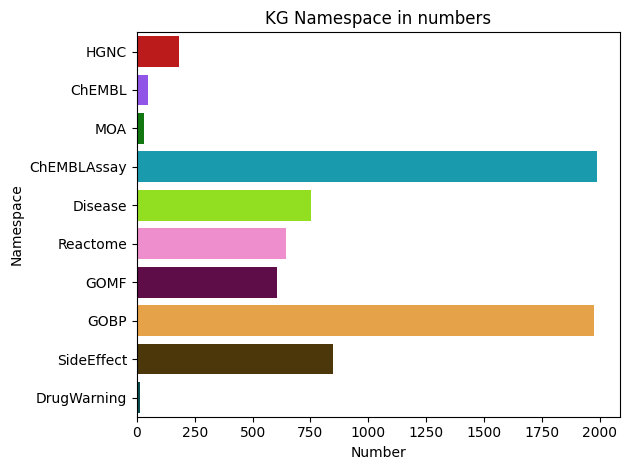

In [81]:
xx = KG_namespace_plot(tnd,'tnd')

# Miscellaneous

# plots and figures for manuscript

In [83]:
df = pd.read_csv('../data/NTDdrugs_properties.csv',index_col=0)

In [3]:
cols = list(df.columns)

In [4]:
cols

['drugId',
 'smiles',
 'Violation(s)_ro5',
 'Lipinski_ro5',
 'MW',
 'HBA',
 'HBD',
 'LogP',
 'Ghose',
 'AtomNum',
 'MolRefractivity',
 'Veber',
 'RotBond',
 'TPSA',
 'REOS',
 'Charge',
 'HeavyAtom',
 'QED',
 'RingNum',
 'phase']

In [5]:
cols = ['drugId',
 'smiles',
 'MW',
 'HBA',
 'HBD',
 'LogP',
 'AtomNum',
 'MolRefractivity',
 'RingNum',
 'RotBond',
 'TPSA',
 'Charge',
 'HeavyAtom',
 'Violation(s)_ro5',
 'Lipinski_ro5',
 'Ghose',
 'Veber',
 'REOS',
 'QED',
 'phase']

In [6]:
df = df[cols]

In [7]:
df.head()

,drugId,smiles,MW,HBA,HBD,LogP,AtomNum,MolRefractivity,RingNum,RotBond,TPSA,Charge,HeavyAtom,Violation(s)_ro5,Lipinski_ro5,Ghose,Veber,REOS,QED,phase
0,CHEMBL1282,CC(C)Cn1cnc2c(N)nc3ccccc3c21,240.310,4,2,2.8227,18,74.2844,3,2,56.73,0,18,0,0,1,0,0,0,3
1,CHEMBL3989515,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,334.397,6,2,0.8608,23,85.8045,3,4,86.71,0,23,0,0,0,0,0,0,3
2,CHEMBL976,O=C(C1CCCCC1)N1CC(=O)N2CCc3ccccc3C2C1,312.413,4,0,2.5349,23,87.7550,4,1,40.62,0,23,0,0,0,0,0,0,4
3,CHEMBL1483,CCCSc1ccc2[nH]c(NC(=O)OC)nc2c1,265.338,5,2,3.2433,18,73.1364,2,4,67.01,0,18,0,0,1,0,0,0,3
4,CHEMBL376488,COc1nc2ccc(Br)cc2cc1[C@@H](c1ccccc1)[C@@](O)(C...,555.516,4,1,7.1305,37,155.2958,5,8,45.59,0,37,2,1,1,0,1,1,2


In [8]:
filter_cols = ['Lipinski_ro5',
 'Ghose',
 'Veber',
 'REOS',
 'QED']

In [9]:
df_filters = df[filter_cols]

In [10]:
df_filters.head()

,Lipinski_ro5,Ghose,Veber,REOS,QED
0,0,1,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,1,0,0,0
4,1,1,0,1,1


In [11]:
df = df_filters
df2 = df.stack().groupby(level=[1]).value_counts().unstack()
# Preferred order of stacked bar elements
stack_order = [0, 1]
df2 = df2[stack_order]

In [12]:
df2

,0,1
Ghose,12,34
Lipinski_ro5,32,14
QED,23,23
REOS,20,26
Veber,31,15


In [13]:
# import matplotlib library 
import matplotlib.pyplot as plt 
#%matplotlib inline

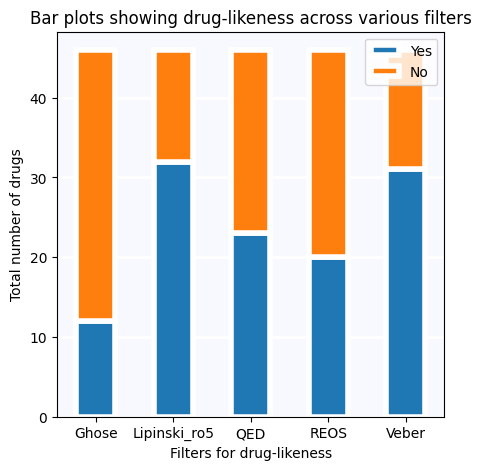

In [107]:
xx = df2.plot.bar(rot=0, stacked=True,
                  figsize = [5,5],
                  title='Bar plots showing drug-likeness across various filters',
                  xlabel = 'Filters for drug-likeness',
                  ylabel = 'Total number of drugs',
                  #table = df2,
                  linewidth = 4,
                  edgecolor='white', 
                  #grid = 2

                 )

#plt.style.use('default')
xx.set_facecolor("ghostwhite")
#%matplotlib inline

xx.set_axisbelow(True)
xx.yaxis.grid(color='white', linewidth = 2)
#_ = xx.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
xx.legend(['Yes', "No"])
#xx.axis('on')
# plt.subplots_adjust(top=2)
# plt.tight_layout()
# plt.subplots_adjust(bottom=0.5)

In [98]:
plt.savefig('data/misc/NTD_drug_profiles.png', dpi = 300)

<Figure size 640x480 with 0 Axes>

In [108]:

xx.get_figure().savefig('data/misc/NTD_drug_profiles.png', format='png', dpi = 1000)

In [21]:
testdf = df_filters

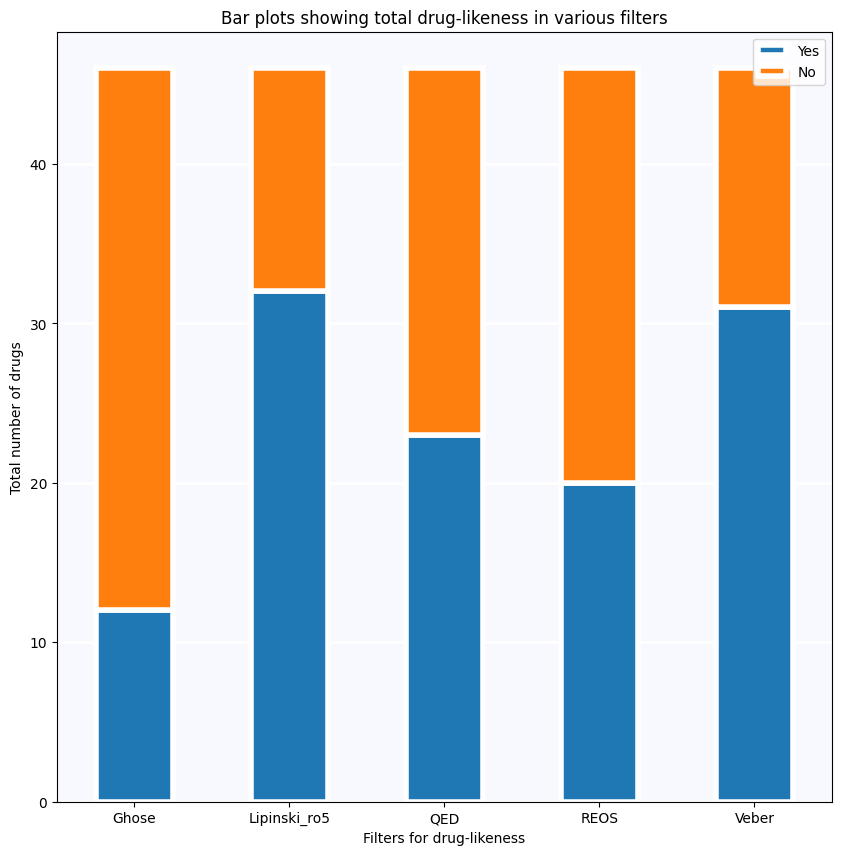

In [102]:
xx.get_figure()

In [22]:
testdf['Flag'] = testdf.sum(axis=1, numeric_only=True)

In [42]:
testdf

,Lipinski_ro5,Ghose,Veber,REOS,QED,Flag
0,0,1,0,0,0,1
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,1,0,0,0,1
4,1,1,0,1,1,4
5,0,0,0,0,0,0
6,0,1,0,1,0,2
7,1,1,0,1,1,4
8,0,0,0,0,0,0
9,0,0,0,0,0,0


In [23]:
df['Flag'] = list(testdf['Flag'])

In [45]:
xx = df[df['Flag'] == 0]
mean_xx = xx['MW'].mean()
mean_xx

339.19880000000006

In [27]:
aa = df[df['Flag'] == 5]
len(aa)

12

In [32]:
df['Flag'] = df_filters['Flag']

In [38]:
import os
print(os.getcwd())

C:\Users\reagon.karki\Documents\GitHub\kgg


In [39]:
df.to_csv('data/misc/NTD_drugs_revision.csv')

In [ ]:
import py2neo

In [ ]:
## to Neo4j
# Exporting graph to Neo4J
import py2neo
node_map = {}

# NEO4J_USER = 'yojana'
# NEO4J_PASS = 'abc'

#neo_connection = py2neo.Graph('bolt://localhost:7687', auth=('neo4j', 'itmp'),name='mpoxkg')
neo_connection = py2neo.Graph('bolt://localhost:7687', auth=('tndkg', 'tnd'),name = 'tnd')
neo_connection.delete_all()
tx = neo_connection.begin()

nodes = list(tnd)

dbio = nx.get_node_attributes(tnd,'3Dbio')
uprot = nx.get_node_attributes(tnd,'UniProt')
chembl = nx.get_node_attributes(tnd,'ChEMBL')
uprot_predicted = nx.get_node_attributes(tnd,'Type')

for node in tqdm(nodes, desc="nodes"):
    attrs = {"namespace": node.namespace}

    if node.name and node.identifier:
        attrs["name"] = node.name
        attrs["identifier"] = node.identifier
    elif node.identifier and not node.name:
        attrs["name"] = node.identifier
    elif node.name and not node.identifier:
        attrs["name"] = node.name
    
    if node in dbio:
        attrs['3Dbio'] = dbio[node]
        
    if node in uprot:
        attrs['UniProt'] = uprot[node]
        
    if node in chembl:
        attrs['ChEMBL'] = chembl[node]
        
    if node in uprot_predicted:
        attrs['Type'] = uprot_predicted[node]

    node_map[node] = py2neo.Node(node.function, **attrs)

    tx.create(node_map[node])

edges = tnd.edges(keys=True, data=True)

for u, v, key, node in tqdm(edges, desc="edges"):
    rel_type = node['relation']

    d = node.copy()
    del d['relation']

    attrs = {}

    annotations = d.pop('annotations', None)
    if annotations:
        for annotation, values in annotations.items():
            attrs[annotation] = list(values)

    citation = d.pop('citation', None)
    if citation:
        attrs['citation'] = citation.curie

    if 'evidence' in d:
        attrs['evidence'] = d['evidence']

    rel = py2neo.Relationship(node_map[u], rel_type, node_map[v], key=key, **attrs)
    tx.create(rel)
    
tx.commit()